In [150]:
import json
from parsivar import Normalizer, Tokenizer, FindStems
from hazm import stopwords_list
import matplotlib.pyplot as plt
import math
import numpy as np
import operator
from itertools import permutations
import re

In [2]:
class Term:
    
    def __init__(self, string):
        self.string = string
        self.total_freq = 0
        self.pos_in_doc = {} 
        self.freq_in_doc = {} 
        
    def set_total_freq(self, total_freq):
        self.total_freq = total_freq

    def set_pos_in_doc(self, pos_in_doc):
        self.pos_in_doc = pos_in_doc

    def set_freq_in_doc(self, freq_in_doc):
        self.freq_in_doc = freq_in_doc
        
    def get_docs(self):
        return self.pos_in_doc.keys()

    def update_posting(self, doc_id, term_position):
        
        if doc_id not in self.pos_in_doc:
            self.pos_in_doc[doc_id] = []
            self.freq_in_doc[doc_id] = 1
            
        self.pos_in_doc[doc_id].append(term_position)
        self.freq_in_doc[doc_id] += 1
        self.total_freq += 1
        

In [3]:
def read_json(path):
    json_file = open(path)
    json_data = json.load(json_file)
    return json_data

In [4]:
def get_documents(data):
    documents = []
    for i in data:
        documents.append(data[i]['content'])
    return documents

In [5]:
def get_title_url(json_data, doc_id):
    title = json_data[doc_id]['title']
    url = json_data[doc_id]['url']
    return title, url

In [185]:
def preprocess(docs, remove_stop_words, stemming_flag):

    normalizer = Normalizer()
    tokenizer = Tokenizer()
    stemmer = FindStems()
    documents_tokens = []
    
    for document in docs:
        normalized_doc = normalizer.normalize(document)

        tokens = tokenizer.tokenize_words(normalized_doc)
        translation_table = str.maketrans('', '', "><.،؟؛:{}\|+ـ()*&^٪$#❊/[]=-«»")
        
        final_tokens = []
        for token in tokens:
            token = token.translate(translation_table)
            
            if token == '':
                continue
                
            if stemming_flag:
                token = stemmer.convert_to_stem(token)
            
            if remove_stop_words:
                if token in stopwords_list():
                    continue
            
            final_tokens.append(token)
            
        documents_tokens.append(final_tokens)
        
    return documents_tokens

In [7]:
def create_positional_index(docs):
    terms_dict = {} 
    for doc_id in range(len(docs)):
        doc = docs[doc_id]
        for pos in range(len(doc)):
            term = doc[pos]
            if term in terms_dict:
                term_obj = terms_dict[term]
            else:
                term_obj = Term(term)
                
            term_obj.update_posting(doc_id, pos)
            terms_dict[term] = term_obj
            
    return terms_dict

In [8]:
def save_index(index, file_name):
    
    positional_index_json = {}
    
    for term_str, term_object in index.items():
        positional_index_json[term_str] = term_object.__dict__
        
    with open(file_name, 'w', encoding='utf-8') as json_file:
        json.dump(positional_index_json, json_file, indent=4, ensure_ascii=False)

In [9]:
def load_index(file_name):
    
    positional_index = {}
    
    with open(file_name, 'r', encoding='utf-8') as json_file:
        positional_index_json = json.load(json_file)
        
    for term in positional_index_json:
        term_object = Term(string=term)
        term_object.set_total_freq(positional_index_json[term]["total_freq"])
        term_object.set_pos_in_doc(positional_index_json[term]["pos_in_doc"])
        term_object.set_freq_in_doc(positional_index_json[term]["freq_in_doc"])
        positional_index[term] = term_object
        
    return positional_index

In [10]:
json_data = read_json('IR_data_news_12k.json')
documents = get_documents(json_data)

In [11]:
documents_tokens = preprocess(documents, remove_stop_words=True, stemming_flag=True)
index_without_stop_words = create_positional_index(documents_tokens)

In [12]:
documents_tokens = preprocess(documents, remove_stop_words=False, stemming_flag=True)
index_with_stop_words = create_positional_index(documents_tokens)

In [17]:
def plot_zipf(index, stop_words_flag):
    
    sorted_index = sorted(index.values(), key=operator.attrgetter('total_freq'), reverse=True)

    max_freq = sorted_index[0].total_freq

    log_rank = []
    log_freq = []
    log_cf = []
    
    for i, term in enumerate(sorted_index):
        log_rank.append(math.log(i+1, 10))
        log_freq.append(math.log(term.total_freq, 10))
        log_cf.append(math.log(max_freq/(i+1), 10))

    plt.plot(log_rank, log_freq)
    plt.plot(log_rank, log_cf)
    
    plt.xlabel('log10 rank')
    plt.ylabel('log10 frequency')
    
    if stop_words_flag:
        plt.title("Zipf's law before removing stop words")
    else:
        plt.title("Zipf's law after removing stop words")
    plt.show()

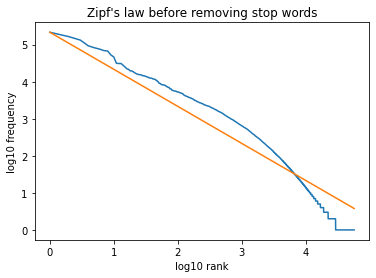

In [18]:
plot_zipf(index_with_stop_words, stop_words_flag=True)

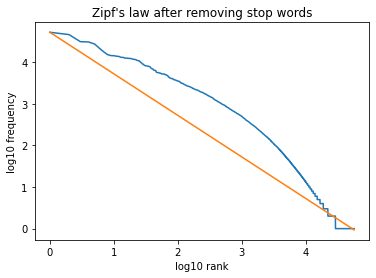

In [19]:
plot_zipf(index_without_stop_words, stop_words_flag=False)

In [20]:
def get_collection_vocab_size(docs, stemming_flag):

    docs_tokens = preprocess(docs, remove_stop_words=True, stemming_flag=stemming_flag)
    collection_size = 0
    
    for doc in docs_tokens:
        collection_size += len(doc)
        
    index = create_positional_index(docs_tokens)
    vocab_size = len(index)
    
    return collection_size, vocab_size

In [21]:
doc_length_list = [500, 1000, 1500, 2000]

T_with_stem = []
T_without_stem = []
M_with_stem = []
M_without_stem = []

for num in doc_length_list:
    collection_size, vocab_size = get_collection_vocab_size(documents[:num], True)
    print('number of docs: ', num, '  vocab size: ', vocab_size, '  collection size: ', collection_size, ' stemming: True')
    T_with_stem.append(collection_size)
    M_with_stem.append(vocab_size)
    collection_size, vocab_size = get_collection_vocab_size(documents[:num], False)
    print('number of docs: ', num, '  vocab size: ', vocab_size, '  collection size: ', collection_size, ' stemming: False')
    T_without_stem.append(collection_size)
    M_without_stem.append(vocab_size)

number of docs:  500   vocab size:  7728   collection size:  80124  stemming: True
number of docs:  500   vocab size:  10055   collection size:  75314  stemming: False
number of docs:  1000   vocab size:  11292   collection size:  164169  stemming: True
number of docs:  1000   vocab size:  15025   collection size:  154262  stemming: False
number of docs:  1500   vocab size:  13625   collection size:  248070  stemming: True
number of docs:  1500   vocab size:  18345   collection size:  232838  stemming: False
number of docs:  2000   vocab size:  15584   collection size:  326270  stemming: True
number of docs:  2000   vocab size:  21008   collection size:  306138  stemming: False


In [24]:
def plot_heaps():
    
    log_M_with_stem = np.log10(M_with_stem)
    log_T_with_stem = np.log10(T_with_stem)
    log_M_without_stem  = np.log10(M_without_stem)
    log_T_without_stem = np.log10(T_without_stem)

    plt.plot(log_T_with_stem, log_M_with_stem)
    [b, log_k] = np.polyfit(log_T_with_stem, log_M_with_stem, 1)
    plt.plot(log_T_with_stem, b * log_T_with_stem + log_k)
    

    plt.plot(log_T_without_stem, log_M_without_stem)
    [b, log_k] = np.polyfit(log_T_without_stem, log_M_without_stem, 1)
    plt.plot(log_T_without_stem, b * log_T_without_stem + log_k)

    plt.title("Heaps' Law")
    plt.legend(["Actual Values after stemming", "Heaps' Law after stemming",
                "Actual Values before stemming", "Heaps' Law before stemming"])
    plt.xlabel('log10 T')
    plt.ylabel('log10 M')
    plt.show()

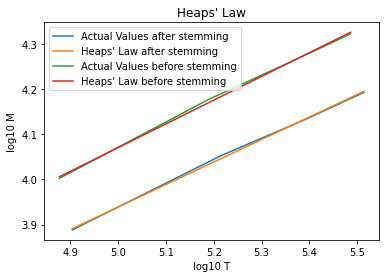

In [25]:
plot_heaps()

In [26]:
save_index(index_without_stop_words, 'index_without_stop_words.json')

In [27]:
save_index(index_with_stop_words, 'index_with_stop_words.json')

In [28]:
positional_index = load_index('index_without_stop_words.json')

In [29]:
def positional_intersect(pos_dict_1, pos_dict_2, k):
    
    doc_ids_1 = list(pos_dict_1.keys())
    doc_ids_2 = list(pos_dict_2.keys())
    doc_ids_1.sort()
    doc_ids_2.sort()
    
    answer = []
    i, j = 0, 0
    
    while i < len(doc_ids_1) and j < len(doc_ids_2):
        doc_id_1 = doc_ids_1[i]
        doc_id_2 = doc_ids_2[j]

        if doc_id_1 == doc_id_2:
            pos_list_1 = pos_dict_1[doc_id_1]
            pos_list_2 = pos_dict_2[doc_id_2]

            for pos in pos_list_1:
                if pos + k in pos_list_2 or pos - k in pos_list_2:
                    answer.append(doc_id_1)

            i, j = i + 1, j + 1
            
        elif doc_id_1 < doc_id_2:
            i += 1
        else:
            j += 1

    return answer

In [30]:
def process_phrase(tokens):
    
    result = []
    
    for biword in permutations(tokens, 2):
        w1 = biword[0]
        w2 = biword[1]
        
        if (w1 not in positional_index.keys()) or (w2 not in positional_index.keys()):
            return []
        
        indx1 = tokens.index(w1)
        indx2 = tokens.index(w2)
        pos_dic_1 = positional_index.get(w1).pos_in_doc
        pos_dic_2 = positional_index.get(w2).pos_in_doc  
        k = abs(indx1-indx2)
        docs = positional_intersect(pos_dic_1, pos_dic_2, k)
        
        if len(result) == 0:
            result = docs
        else:
            result = list(set(result) & set(docs))
            
    return result

In [377]:
def process_query(not_words=[], phrases=[], words=[]):
    ranks={}
    
    for token in words:
        if token in positional_index.keys():
            for doc_id in positional_index[token].get_docs():
                if doc_id in ranks.keys():
                    ranks[doc_id]+=1
                else:
                    ranks[doc_id]=1
    
    for phrase in phrases:
        for doc_id in process_phrase(phrase):
            if doc_id in ranks.keys():
                ranks[doc_id] += 1
            else:
                ranks[doc_id] = 1
    
    not_words_docs = []
    for word in not_words:
        doc_ids = positional_index[word].get_docs()
        for doc_id in doc_ids:
            not_words_docs.append(doc_id)
            
    if len(ranks) > 0:
        for doc in not_words_docs:
            if doc in ranks.keys():
                del ranks[doc]
                
    ranks = dict(sorted(ranks.items(), key=lambda x: x[1], reverse=True))
    
    return ranks

In [378]:
def get_not_terms(query):
    res = []
    splitted_query = query.split()
    indices = [i for i in range(len(splitted_query)) if splitted_query[i]=='!']
    for i in indices:
        res.append(splitted_query[i+1])
    return res

In [379]:
def get_phrase(query):
    res = []
    quoted = re.compile('"[^"]*"')
    for value in quoted.findall(query):
        value = value.replace('"', '').strip().split()
        res.append(value)
    return res

In [380]:
def search_query(query):
    query = ' '.join(preprocess([query], True, True)[0])
    phrases = get_phrase(query)
    flat_phrases = [item for sublist in phrases for item in sublist]
    not_words = get_not_terms(query)
    query = query.replace('"', '')
    query = query.replace('!', '')
    splitted_query = query.split()
    words = [x for x in splitted_query if x not in not_words and x not in flat_phrases]
    output = process_query(not_words=not_words, phrases=phrases, words=words)  
    return output

In [381]:
def print_output(output_dict):
    ids = list(output_dict.keys())[:5]
    for id in ids:
        title, url = get_title_url(json_data, id)
        print('title: ', title, '\nurl: ', url)

In [382]:
query = 'تحریم‌های آمریکا علیه ایران'
res = search_query(query)
print_output(res)

title:  خبرگزاری فارس ۱۹ ساله شد 
url:  https://www.farsnews.ir/news/14001122000809/خبرگزاری-فارس-۱۹-ساله-شد
title:  اصولی: فدراسیون فوتبال جمهوری اسلامی ایران هستیم نه جزیره مستقل/ با گفتار ساختارشکنانه فدراسیون را به ناکجا آباد می‌برند 
url:  https://www.farsnews.ir/news/14001117000518/اصولی-فدراسیون-فوتبال-جمهوری-اسلامی-ایران-هستیم-نه-جزیره-مستقل-با
title:  احتمال مبادله نازنین زاغری در ازای 530میلیون دلار 
url:  https://www.farsnews.ir/news/14001223001080/احتمال-مبادله-نازنین-زاغری-در-ازای-530میلیون-دلار
title:  متکی: آمریکا با ابزار ناتو به دنبال تجزیه روسیه است 
url:  https://www.farsnews.ir/news/14001222000749/متکی-آمریکا-با-ابزار-ناتو-به-دنبال-تجزیه-روسیه-است
title:  توضیحات یک منبع آگاه درباره وقفه مذاکرات وین 
url:  https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین


In [292]:
query = 'تحریم‌های آمریکا ! ایران'
res = search_query(query)
print_output(res)

title:  ادامه تحریم‌های سیاسی علیه المپیک پکن/ژاپن هم به صف منتقدان پیوست 
url:  https://www.farsnews.ir/news/14001003000306/ادامه-تحریم‌های-سیاسی-علیه-المپیک-پکن-ژاپن-هم-به-صف-منتقدان-پیوست
title:  انتقاد دانشجویان ایرانی در اروپا به برخورد دوگانه مدعیان حقوق بشر با قضایای اوکراین و جنایت‌های آل سعود 
url:  https://www.farsnews.ir/news/14001224000014/انتقاد-دانشجویان-ایرانی-در-اروپا-به-برخورد-دوگانه-مدعیان-حقوق-بشر-با
title:  محو رژیم صهیونیستی از آرمان‌های نظام اسلامی حذف نشده است 
url:  https://www.farsnews.ir/news/14001222000379/محو-رژیم-صهیونیستی-از-آرمان‌های-نظام-اسلامی-حذف-نشده-است
title:  تجربه نشان داده به عهد آمریکا در مذاکرات نمی‌شود اعتماد کرد 
url:  https://www.farsnews.ir/news/14001203000366/تجربه-نشان-داده-به-عهد-آمریکا-در-مذاکرات-نمی‌شود-اعتماد-کرد
title:  سود مافیای اسلحه‌سازی آمریکا در ناامن بودن جهان است 
url:  https://www.farsnews.ir/news/14001211000898/سود-مافیای-اسلحه‌سازی-آمریکا-در-ناامن-بودن-جهان-است


In [293]:
query = '"کنگره ضدتروریست"'
res = search_query(query)
print_output(res)

title:  توضیحات یک منبع آگاه درباره وقفه مذاکرات وین 
url:  https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین


In [294]:
query = '"تحریم هسته‌ای" آمریکا ! ایران'
res = search_query(query)
print_output(res)

title:  بمب خبری بازگشت مسی به بارسلونا خنثی شد/پای جام جهانی درمیان است 
url:  https://www.farsnews.ir/news/14001221000109/بمب-خبری-بازگشت-مسی-به-بارسلونا-خنثی-شد-پای-جام-جهانی-درمیان-است
title:  منچستریونایتد به دنبال بهترین بازیکن دنیا / زوج «رونالدو - لواندوفسکی» در اولدترافورد +عکس 
url:  https://www.farsnews.ir/news/14001220000373/منچستریونایتد-به-دنبال-بهترین-بازیکن-دنیا--زوج-رونالدو--لواندوفسکی
title:  راهیابی بانوی سنگنورد کشورمان به مسابقات جهانی آمریکا 
url:  https://www.farsnews.ir/news/14001217000994/راهیابی-بانوی-سنگنورد-کشورمان-به-مسابقات-جهانی-آمریکا
title:  مدرس جهانی تنیس روی میز: صحبت‌های عیلقارداشی بیشتر شوخی است تا جدی/در همه زمینه‌ها سقوط کردیم 
url:  https://www.farsnews.ir/news/14001214000887/مدرس-جهانی-تنیس-روی-میز-صحبت‌های-عیلقارداشی-بیشتر-شوخی-است-تا-جدی-در
title:  راجر فدرر از زمان بازگشتش به میادین پرده برداشت 
url:  https://www.farsnews.ir/news/14001214000736/راجر-فدرر-از-زمان-بازگشتش-به-میادین-پرده-برداشت


In [295]:
query = '"تحریم هسته‌ای" ایران ! آمریکا'
res = search_query(query)
print_output(res)

title:  ۹ دی یکی از روزهای فراموش نشدنی در تاریخ انقلاب اسلامی است 
url:  https://www.farsnews.ir/news/14001007000363/۹-دی-یکی-از-روزهای-فراموش-نشدنی-در-تاریخ-انقلاب-اسلامی-است
title:  اعلام زمان قرعه کشی جام باشگاه های فوتسال آسیا 
url:  https://www.farsnews.ir/news/14001224001005/اعلام-زمان-قرعه-کشی-جام-باشگاه-های-فوتسال-آسیا
title:  محل برگزاری نشست‌های خبری سرخابی‌ها؛ مجیدی در سازمان لیگ، گل‌محمدی در تمرین پرسپولیس 
url:  https://www.farsnews.ir/news/14001224000971/محل-برگزاری-نشست‌های-خبری-سرخابی‌ها-مجیدی-در-سازمان-لیگ-گل‌محمدی-در
title:  ماجدی در نشست با صالحی امیری: امیدوارم در این دوره تیم  المپیک موفق شود 
url:  https://www.farsnews.ir/news/14001224000964/ماجدی-در-نشست-با-صالحی-امیری-امیدوارم-در-این-دوره-تیم-المپیک-موفق
title:  مسابقات تنیس روی میز فیدر قطر| هر4 بانوی ملی پوش ایران حذف شدند 
url:  https://www.farsnews.ir/news/14001224000916/مسابقات-تنیس-روی-میز-فیدر-قطر|-هر4-بانوی-ملی-پوش-ایران-حذف-شدند


In [297]:
query = 'غزه ! ضدتروریست'
res = search_query(query)
print_output(res)

title:  سفر تیم فوتبال معلولان فلسطین به تهران 
url:  https://www.farsnews.ir/news/14001212000749/سفر-تیم-فوتبال-معلولان-فلسطین-به-تهران
title:  بیانیه بسیج ورزشکاران در محکومیت اقدام شرم‌آور سرمربی تیم ملی امید 
url:  https://www.farsnews.ir/news/14000929000204/بیانیه-بسیج-ورزشکاران-در-محکومیت-اقدام-شرم‌آور-سرمربی-تیم-ملی-امید
title:  اقدام تحسین برانگیز سرمربی الجزایر در حمایت از فلسطین/جام قهرمانی به مردم غزه اهدا شد 
url:  https://www.farsnews.ir/news/14000928000274/اقدام-تحسین-برانگیز-سرمربی-الجزایر-در-حمایت-از-فلسطین-جام-قهرمانی-به
title:  اردوغان علاوه بر آرمان فلسطین بر باورهای مردم ترکیه هم پا گذاشت 
url:  https://www.farsnews.ir/news/14001220000842/اردوغان-علاوه-بر-آرمان-فلسطین-بر-باورهای-مردم-ترکیه-هم-پا-گذاشت
title:  نگاه دوگانه برخی جریان‌ها به یمن و اوکراین نشانه سرسپردگی‌شان به آمریکاست 
url:  https://www.farsnews.ir/news/14001209000540/نگاه-دوگانه-برخی-جریان‌ها-به-یمن-و-اوکراین-نشانه-سرسپردگی‌شان-به
